[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/schlichtanders/fall-in-love-with-julia/main?filepath=07%20streaming%20analytics%20-%2001%20OnlineStats.ipynb)

# Introduction to Streaming Analytics in Julia with OnlineStats.jl

Welcome to this little Jupyter Notebook for getting to know real-time processing in Julia.

[![OnlineStats](https://joshday.github.io/OnlineStats.jl/latest/assets/logo.svg)](https://joshday.github.io/OnlineStats.jl/latest/)

[OnlineStats.jl](https://joshday.github.io/OnlineStats.jl/latest/) does statistics and data visualization for big/streaming data via online algorithms. Each algorithm:
- processes data one observation at a time.
- uses O(1) memory.

The perfect building blocks you need for your streaming analysis.

# Basics

In [10]:
using OnlineStats

In [24]:
m = Mean()

Mean: n=0 | value=0.0

In [25]:
supertypes(typeof(m))

(Mean{Float64, EqualWeight}, OnlineStat{Number}, Any)

Stats are subtypes of `OnlineStat{T}` where `T` is the type of a single observation.

## Fit

In [26]:
ys = randn(10)

10-element Vector{Float64}:
 -1.07951222500102
  0.6045938640409401
 -0.0586019073511424
 -0.6322154909908462
 -0.2750862898712892
  2.929904536077595
  0.8138433089916799
 -0.43512481574223166
 -1.0311068613447099
  1.1292896228006608

In [27]:
for y in ys
    fit!(m, y)
    println(m)
end

Mean: n=1 | value=-1.07951
Mean: n=2 | value=-0.237459
Mean: n=3 | value=-0.17784
Mean: n=4 | value=-0.291434
Mean: n=5 | value=-0.288164
Mean: n=6 | value=0.24818
Mean: n=7 | value=0.328989
Mean: n=8 | value=0.233475
Mean: n=9 | value=0.092966
Mean: n=10 | value=0.196598


Stats can be updated with single or multiple observations e.g. `fit!(m, 1)` and `fit!(m, [1,2,3])`.

In [28]:
ys2 = randn(10) .+ 5

10-element Vector{Float64}:
 6.688116466808715
 3.88653851736674
 6.796138094624774
 5.4326370068758205
 4.53734026154239
 5.976078727788369
 3.7385922277496766
 5.909637796398937
 5.322951049648258
 5.4643106396365715

In [29]:
m2 = Mean()
fit!(m2, ys2)

Mean: n=10 | value=5.37523

## Merge

Stats can be merged.

In [30]:
merge!(m, m2)

Mean: n=20 | value=2.78592

# Visualizations

┌ Info: Saved animation to 
│   fn = /home/ssahm/Projects/fall-in-love-with-julia/temp.gif
└ @ Plots /home/ssahm/.julia/packages/Plots/qbc7U/src/animation.jl:114


Plots.AnimatedGif("/home/ssahm/Projects/fall-in-love-with-julia/temp.gif")
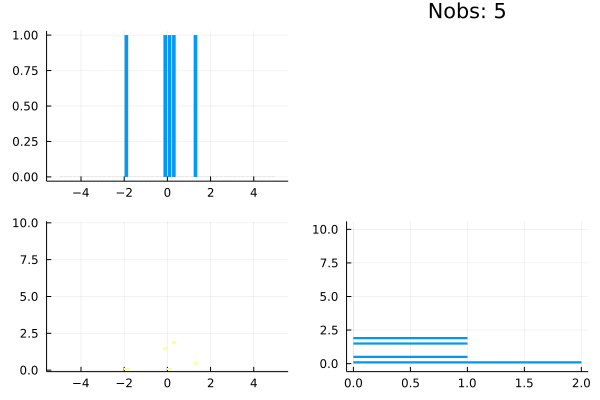

In [11]:
using Plots
using Random

nframes = 100

o = HeatMap(-5:.2:5, 0:.2:10)
anim = @animate for i in 1:nframes 
    x = randn(5i)
    y = Random.randexp(5i)
    fit!(o, zip(x,y))
    plot(o)
end
gif(anim, "temp.gif", fps=10)

# Large Data

In [8]:
run(`kaggle competitions download -c new-york-city-taxi-fare-prediction -p data/`)

User cancelled operation



  7%|██▌                                   | 109M/1.56G [00:12<02:55, 8.88MB/s]


Process(`kaggle competitions download -c new-york-city-taxi-fare-prediction -p data/`, ProcessExited(0))

In [ ]:
run(`unzip data/new-york-city-taxi-fare-prediction.zip -d data/`)  # takes about 1 minute

In [ ]:
; ls data